In [1]:
import re
import csv
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
RE_NUMBERS = re.compile(r'[0-9]+')
RE_NOT_LETTERS = re.compile(r'[^a-zA-Z]+')
RE_SPACES = re.compile(r'[^\S\f\t\n\r]+')

def clean_text(text):
    text = RE_NUMBERS.sub(' NUM ', text)
    text = RE_NOT_LETTERS.sub(' ', text)
    text = RE_SPACES.sub(' ', text)
    return text.lower()

In [3]:
rows = []
with open('tweets/tweets_some_labeled.csv', newline='', encoding='utf-8') as csvfile:
    for row in csvfile.readlines():
        rows += [row.split(';')]

In [4]:
# Cleaning tweets
tweets = [[row[0], clean_text(row[1]), row[2].replace('\r\n','')] for row in rows]
print('Tweets\' set size: ' + str(len(tweets)))

Tweets' set size: 243002


In [5]:
# Tweet takes part on training set if it is labeled (third column)
classified_tweets = [tweet for tweet in tweets if tweet[2] != '']
classified_tweets_text = [tweet[1] for tweet in classified_tweets]
classified_tweets_target = [int(tweet[2]) for tweet in classified_tweets]
print('Training set size: ' + str(len(classified_tweets)))

Training set size: 500


In [6]:
# Vectorizing tweets
tweet_vectorizer = CountVectorizer()
tweet_vectorizer.fit(classified_tweets_text)

vectorized_classified_tweets = tweet_vectorizer.transform(classified_tweets_text)
labels_classified_tweets = np.array(classified_tweets_target)

In [7]:
# Stratified K-fold
# Random training sets in order to choose the best classifier
number_of_folds = 100
stratified_kfold = StratifiedKFold(n_splits=number_of_folds, shuffle=True)

best_classifier = None
best_classifier_score = 0

for i, (train_indices, test_indices) in enumerate(stratified_kfold.split(vectorized_classified_tweets, labels_classified_tweets)):
    current_nb_classifier = MultinomialNB()

    train_instances = vectorized_classified_tweets[train_indices]
    train_classes = labels_classified_tweets[train_indices]
    test_instances = vectorized_classified_tweets[test_indices]
    test_classes = labels_classified_tweets[test_indices]

    current_nb_classifier.fit(train_instances, train_classes)
    score = current_nb_classifier.score(test_instances, test_classes)
    
    if score > best_classifier_score:
        best_classifier = current_nb_classifier
        best_classifier_score = score
        
print(best_classifier_score)

1.0


In [8]:
# Classify all tweets dataset
tweets_text = [tweet[1] for tweet in tweets]
vectorized_tweets = tweet_vectorizer.transform(tweets_text)
labels_tweets = best_classifier.predict(vectorized_tweets)

In [9]:
tweets_dates_labels = [(tweet[0], label) for tweet, label in zip(tweets, labels_tweets)]

tweets_dates_count = []
current_date = ''
for i in range(len(tweets_dates_labels)):
    date, label = tweets_dates_labels[i]
    if (date == current_date):
        head = len(tweets_dates_count) - 1
        tweets_dates_count[head] = (\
            tweets_dates_count[head][0],\
            tweets_dates_count[head][1] + 1,\
            tweets_dates_count[head][2] + label,\
            tweets_dates_count[head][3] + (not label),\
        )
    else:
        tweets_dates_count += [(date, 1, label, not label)]
    current_date = date
    
# print(len(tweets_dates_count))
# print(tweets_dates_count)

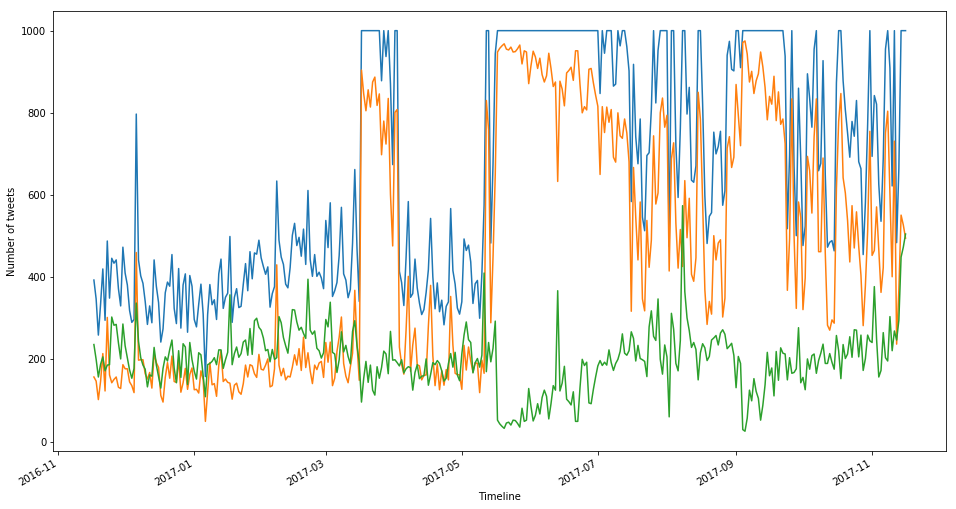

In [10]:
times = pd.date_range(tweets_dates_count[0][0], periods=365)

fig, ax = plt.subplots(figsize=(16, 9))
fig.autofmt_xdate()

plt.xlabel("Timeline")
plt.ylabel("Number of tweets")
plt.plot(times, [tweet[1] for tweet in tweets_dates_count], label='Total tweets')
plt.plot(times, [tweet[2] for tweet in tweets_dates_count], label='Related to JBS delations')
plt.plot(times, [tweet[3] for tweet in tweets_dates_count], label='Not related to JBS delations')
plt.show()